# Demo: WFIRST CGI simulation with WebbPSF

This tutorial will walk you through the basics of using the WebbPSF package to calculate PSFs for WFIRST CGI.

First, we set up the notebook to display plots inline, and to plot images with the origin in the lower left.

In [1]:
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest' 

Populating the interactive namespace from numpy and matplotlib


## Getting Started

In [2]:
import os
#os.environ['WEBBPSF_PATH'] = '../webbpsf-data'
import webbpsf
from webbpsf import wfirst
import ipywidgets
from astropy.io import fits

WebbPSF produces various log messages while it works, using Python's built-in logging mechanism. In order to see them, we need to set up a log handler that will display them on the screen. This is done using the ``setup_logging`` function. 

In [3]:
webbpsf.setup_logging()

WebbPSF log messages of level INFO and above will be shown.
WebbPSF log outputs will be directed to the screen.


We can also choose to save log outputs to a file, if that's desired.

In [4]:
webbpsf.setup_logging(filename='my_log.txt')

WebbPSF log messages of level INFO and above will be shown.
WebbPSF log outputs will be directed to the screen.
WebbPSF log outputs will also be saved to file my_log.txt


## Shaped pupil coronagraph PSF

Now let's get started with some calculations. To calculate a PSF, we first instantiate an instrument object: 

In [5]:
spc = wfirst.CGI()

Now we set the coronagraph observing mode and filter. There are two modes implemented so far, both shaped pupil designs: 'CHARSPC' and 'DISKSPC' -- these are the characterization and debris disk imaging modes of CGI, respectively. The filters choices for 'CHARSPC' are 'F660','F770', and 'F890' (18% bandwidth IFS filters centered at 660 nm, 770 nm, and 890 nm). Filter choices for 'DISKSPC' are 'F465', 'F565', 'F835', and 'F865', all 10% bandwidth imaging filters. 

In [6]:
spc.mode = 'CHARSPC'
spc.filter = 'F770'

And then call its ``calcPSF`` function.  Note the log output describes various details of the calculation as it proceeds. The returned result is a fits HDUList object containing both the image data and its associated metadata in the header. 

[webbpsf] Setting up PSF calculation for CGI
[  poppy] Computing wavelength weights using synthetic photometry for F770...
[webbpsf] PSF calc using fov_arcsec = 1.600000, oversample = 4, number of wavelengths = 1
[webbpsf] Creating optical system model:
[  poppy] Initialized OpticalSystem: WFIRST+CGI
[  poppy] WFIRST Pupil: Loaded amplitude transmission from /Users/ntz/WFIRST/webbpsf-data/AFTA_CGI_C5_Pupil_onax_1000px.fits
[  poppy] Added pupil plane: WFIRST Pupil
[  poppy] CHARSPC: Loaded amplitude transmission from /Users/ntz/WFIRST/webbpsf-data/CGI/optics/CHARSPC_SP_1000pix.fits.gz
[  poppy] Added pupil plane: CHARSPC
[  poppy] Optic from /Users/ntz/WFIRST/webbpsf-data/CGI/optics/CHARSPC_FPM_25WA90_2x65deg_-_FP1res8_evensamp_D144_F770.fits.gz: Loaded amplitude transmission from /Users/ntz/WFIRST/webbpsf-data/CGI/optics/CHARSPC_FPM_25WA90_2x65deg_-_FP1res8_evensamp_D144_F770.fits.gz
[  poppy] Added image plane: Optic from /Users/ntz/WFIRST/webbpsf-data/CGI/optics/CHARSPC_FPM_25WA90_2

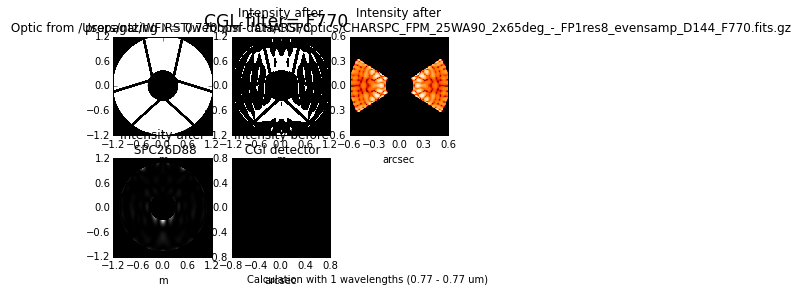

In [7]:
monopsf = spc.calcPSF(nlambda=1, fov_arcsec=1.6, display=True)

We can display the PSF that we have just created:

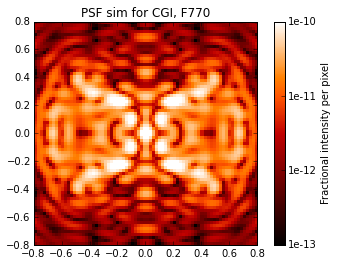

In [8]:
webbpsf.display_PSF(monopsf,ext=1,vmin=1e-13, vmax=1e-10)

## Integral field spectrograph PSF with the characterization SPC

In [9]:
webbpsf.setup_logging('ERROR') # Reduce the verbosity

WebbPSF log messages of level ERROR and above will be shown.
WebbPSF log outputs will be directed to the screen.


To approximate the PSF seen by the integral field spectrograph, we can form an array of monochromatic PSFs computed at wavelengths spanning the bandpass:

In [10]:
ifs_spc = wfirst.CGI()
ifs_spc.mode = 'CHARSPC'
ifs_spc.filter = 'F770'

filter_fname = ifs_spc._filters[ifs_spc.filter].filename
filter_hdulist = fits.open(filter_fname)
wave_beg = (float(filter_hdulist[1].header.get('LAMBDA0')) - float(filter_hdulist[1].header.get('DELTALAM'))/2)
wave_end = (float(filter_hdulist[1].header.get('LAMBDA0')) + float(filter_hdulist[1].header.get('DELTALAM'))/2)
deltalam_ifs = float(filter_hdulist[1].header.get('LAMBDA0'))/70. # Assume spectral resolution R = 70
Nchan = (int(np.floor((wave_end - wave_beg)/deltalam_ifs))/2)*2 + 1 # Number of channels, forced to an odd integer
wavelens = np.linspace(wave_beg, wave_end, Nchan) * 1e-10 # all wavelengths to model, in meters

lamoD_asec = float(filter_hdulist[1].header.get('LAMBDA0'))*1e-10/(2*ifs_spc.PUPIL_RADIUS) * 180/np.pi * 3600
print("System diffraction resolution element scale (lambda_0/D) in arcsec: %.3f" % lamoD_asec)
print("IFS spectral parameters: %d channels of characteristic spectral width %.2f nm," % (Nchan,deltalam_ifs/10.))
print("ranging from %d nm to %d nm, centered on %d nm" % (wavelens[0]*1e9, wavelens[-1]*1e9, wavelens[Nchan/2]*1e9))
filter_hdulist.close()

System diffraction resolution element scale (lambda_0/D) in arcsec: 0.066
IFS spectral parameters: 13 channels of characteristic spectral width 11.00 nm,
ranging from 700 nm to 839 nm, centered on 770 nm


In [11]:
ifs_spc.options['source_offset_r'] = 0 # arcsec
ifs_spc.options['source_offset_theta'] = 0 # deg w.r.t. North

ifs_psf_onax = []
for w in wavelens:
    psf_onax = ifs_spc.calcPSF(monochromatic=w, fov_arcsec=1.64, oversample=4, display=False)
    ifs_psf_onax.append(psf_onax)

In [12]:
ifs_spc.options['source_offset_r'] = 6*lamoD_asec # 6 lam/D in arcsec
ifs_spc.options['source_offset_theta'] = -90. # deg w.r.t. North
ifs_psf_offax = []
peak_offax = []
for wi, w in enumerate(wavelens):
    psf_offax = ifs_spc.calcPSF(monochromatic=w, fov_arcsec=1.64, oversample=4, display=False)
    ifs_psf_offax.append(psf_offax)
    peak_offax.append(psf_offax[1].data.max())
    # Normalize by the off-axis peak to change to units of contrast
    ifs_psf_onax[wi-1][1].data = ifs_psf_onax[wi-1][1].data/peak_offax[wi-1]

## Plot the polychromatic PSF of the IFS in contrast units. 

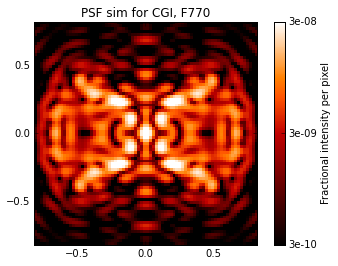

In [13]:
def plt_ifs_psf_onax(wchan):
    webbpsf.display_PSF(ifs_psf_onax[wchan-1],ext=1,vmin=3e-10,vmax=3e-8);
ipywidgets.interact(plt_ifs_psf_onax, wchan=(1,Nchan));

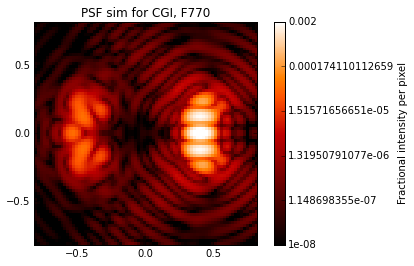

In [14]:
def plt_ifs_psf_offax(wchan):
    webbpsf.display_PSF(ifs_psf_offax[wchan-1],ext=1,vmax=2e-3);
ipywidgets.interact(plt_ifs_psf_offax, wchan=(1,len(wavelens)));

# Debris disk mode SPC

In [15]:
diskcg = wfirst.CGI()
diskcg.mode = 'DISKSPC'
diskcg.filter = 'F565'
diskcg.options['source_offset_r'] = 0 # arcsec
diskcg.options['source_offset_theta'] = 0 # deg w.r.t. North

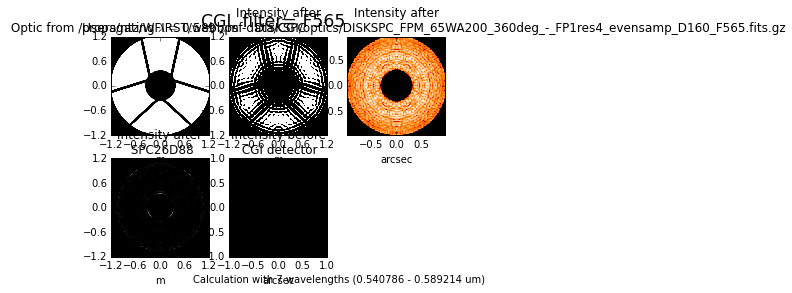

In [16]:
diskpsf_onax = diskcg.calcPSF(nlambda=7, fov_arcsec=2., oversample=4, display=True)

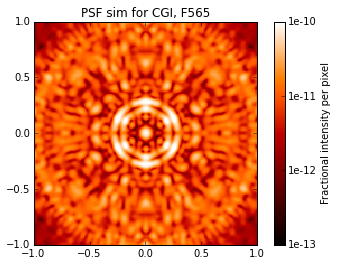

In [17]:
webbpsf.display_PSF(diskpsf_onax,ext=1,vmin=1e-13, vmax=1e-10)

## Off-axis PSF

In [18]:
diskcg.options['source_offset_r'] = 0.6 # arcsec
diskcg.options['source_offset_theta'] = -45. # deg w.r.t. North

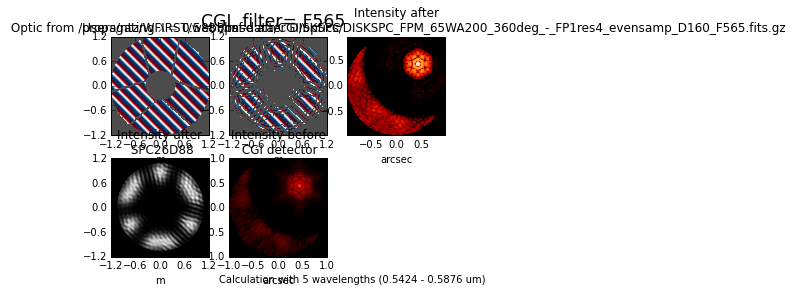

In [19]:
diskpsf_offax = diskcg.calcPSF(nlambda=5, fov_arcsec=2., oversample=4, display=True)
diskpsf_offax_peak = diskpsf_offax[1].data.max()

In [24]:
# Form a simple bright companion scene by summing the on-axis and off-axis PSF, the latter scaled by 1E-7.
comb_img = (diskpsf_onax[1].data + diskpsf_offax[1].data*1e-7)/diskpsf_offax_peak # Contrast units
comb_hdu = fits.PrimaryHDU(comb_img, header=diskpsf_onax[1].header)
comb_hdulist = fits.HDUList([comb_hdu])

### Plot composite disk SPC PSF (on-axis + off-axis@1E-7 contrast) in units of contrast 

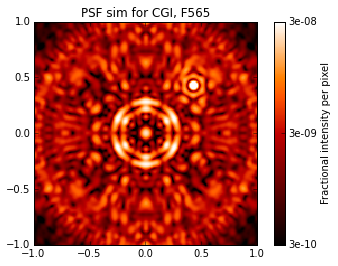

In [25]:
webbpsf.display_PSF(comb_hdulist,vmin=3e-10, vmax=3e-8)